# Data Wrangling - WeRateDogs

> Project initiative aims at covering fundamental steps before crunching data: Data wrangling.
It emcompasses many tasks, very often tedious ones. But all necessary to carry on with proper data analysis.

>Primarly, collecting the data we need from multiple sources and different fashions. Then, assessing it vizually and progammatically to identify potential pitfalls and apply all transformations that would ease the remaining steps of the process.
>Finally, go through the different data collected, either via relevant vizualizations and/or programmatic methods to get the essence of it and hopefully find the answers to our initial questions.





## Table of Contents

* [1.Gather](#gather)
    * [1.1 Read original file(.csv)](#readcsv)
        
    * [1.2 Read from Twitter api](#readapi)
        * [1.2.1 Configure credentials for API](#apicredentials)
        * [1.2.2 Query Tweeter API & store results (json) in file](#queryapi)
        * [1.2.3 Read json file content in a dataframe](#readjson)
        
    * [1.3 Read from image predictions file](#readimg)
        * [1.3.1 Download file & save results as .tsv file](#savetsv)   


* [2.Assessment](#assess)
    * [2.1 Assess original file(csv)](#assessoriginalecsv)
    * [2.2 Report - original file](#reportoriginalcsv)
    * [2.3 Assess image predictions file](#assessimgpreds)
    * [2.4 Report - image predictions file assesment](#reportimgpreds)
    * [2.5 Assess json data in dataframe](#assessjson)
    * [2.6 Report - json data assesment](#reportjson)
    * [2.7 Summary - assessment report](#finalreport)
    

    
* [3.Cleaning](#clean)
    * [3.1 Cleaning tasks - original tweet file](#cleanoriginal)
    * [3.2 Cleaning tasks - image predictions](#cleanpreds)
    * [3.2 Cleaning tasks - image predictions](#cleanpreds)
    
    
* [4. Storing, Analyzing & Vizualizing wrangled data](#results)
    * [4.1 Generate output file(s) after wrangled efforts](#wrangled_files)
    * [4.2 Vizualization & Insights on wrangled data](#insights)

To get started, let's import our libraries.

In [2]:
# install dependencies 
import pandas as pd
import numpy as np
import requests
import os
import json
import tweepy
import datetime as dt
from timeit import default_timer as timer
import matplotlib.pyplot as plt


%matplotlib inline
#pip install tweepy

<a id='gather'></a>
## 1.Gather

<a id='readcsv'></a>
### 1.1 Read original file (.csv)

In [3]:
df = pd.read_csv('twitter-archive-enhanced.csv')
print(df.shape)
df.head(2)


(2356, 17)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [4]:
# as required in keypoints - we only need infos for original tweets, retweets have to be removed
df_original_tweets = df[df['retweeted_status_id'].isnull()]
df_original_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

<a id='readapi'></a>
### 1.2 Read from Twitter API (tweepy)

<a id='apicredentials'></a>
##### 1.2.1 Configure credentials for API -- (No need to run the code in cell)

In [5]:
# credentials to query twitter api (REMOVED BEFORE SUBMISSION)
consumer_key = '{user-consumer-key}'
consumer_secret = '{user-consumer-secret}'
access_token = '{user-access-token}'
access_secret = '{user-access-secret}'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# set the wait on rate limit to avoid cancellation
api = tweepy.API(auth,wait_on_rate_limit=True)

In [6]:
#api.get_status(754120377874386944, tweet_mode='extended')
len (df_original_tweets) 

2175

<a id='queryapi'></a>
##### 1.2.2 Query Tweeter API & store results (json) in file

In [10]:
# def a function that can read from any dataframe and return a list of tweet_id - Input required
def get_tweet_id(df_original_tweets):
    tweet_id_list = df_original_tweets['tweet_id']
    return tweet_id_list


# def a function (no input required) that will:
#(a) read list of tweet_id
#(b) get api data for specific tweet_id 
#(c) store the result as json in .txt file
#(d) store any possible exceptions returned from api (ie.deleted tweets)

errors_dict = {}

def get_tweetid_content():
    tweet_id_list = get_tweet_id(df_original_tweets)
    start = timer()
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in tweet_id_list:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                tweet_content = tweet._json
                #return tweet_content
                json.dump(tweet_content, file)
                file.write('\n')
                
            except tweepy.TweepError as e:
                errors_dict[tweet_id] = e
    end = timer()
    print(end - start)
    #print(errors_dict)

get_tweetid_content()

1942.0676191970124


In [11]:
# check for errors - missing tweet_id
errors_dict

{872261713294495745: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 844704788403113984: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 837366284874571778: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 829374341691346946: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 779123168116150273: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 754011816964026368: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 680055455951884288: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}])}

<a id='readjson'></a>
##### 1.2.3 Read json file content in a dataframe

In [7]:
# open file with content saved as json for - each line corresponding to one tweet
with open('tweet_json.txt') as f:
    df_tweet_api = pd.DataFrame(json.loads(line) for line in f)
    
df_tweet_api.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,35155,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,30413,False,False,False,False,en,NaN,NaN,NaN,NaN


In [8]:
# losing 7 tweets as missing in api response
df_tweet_api.shape

(2168, 31)

In [9]:
# select only the cols we need for our analysis
df_tweet_api = df_tweet_api.iloc[:, [0,1,2,3,8,14,20,21,22,23]].copy()


# check if subset operation maintain same num of rows
len(df_tweet_api)

2168

In [10]:
df_tweet_api.head()

,created_at,id,id_str,full_text,source,user,retweet_count,favorite_count,favorited,retweeted
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7413,35155,False,False
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",5515,30413,False,False
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",3640,22863,False,False
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7590,38424,False,False
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",8161,36679,False,False


<a id='readimg'></a>
### 1.3 Read from image predictions file

<a id='savetsv' ></a>
##### 1.3.1 Download file & save results as .tsv file

In [11]:
# url where file is located was provided - Download file using requets library
folder_name='/Users/samy.bencherif/Documents/udacity_courses/ND_data_analyst/ND_data_wrangling'
img_preds_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
download_file = requests.get(img_preds_url)
file_content = download_file.content

with open (os.path.join(folder_name,img_preds_url.split('/')[-1]),mode='wb') as file:
    file.write(file_content)
    

In [12]:
df_img_preds = pd.read_csv("image-predictions.tsv",sep='\t')
df_img_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='assess'></a>
# 2. Assessment

>3 files have to be assesed:
>
>1.csv provided initially (df_original_tweets) -- we know this one was extracted via api but was missing some useful infos and contain useless data (retweet)
>
>2.tsv downloaded from server (df_img_preds)
>
>3.json obtained with twitter api (df_tweet_api)

<a id='assessoriginalecsv'></a>
### 2.1 Assess original file ('twitter-archive-enhanced.csv')

In [346]:
df_original_tweets.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
563,802572683846291456,NaN,NaN,2016-11-26 18:00:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Winnie. She's h*ckin ferocious. Dandel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/802572683...,12,10,Winnie,None,None,None,None
1090,737678689543020544,NaN,NaN,2016-05-31 16:14:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737678689...,11,10,None,None,None,None,None
1610,685532292383666176,NaN,NaN,2016-01-08 18:43:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...","For the last time, WE. DO. NOT. RATE. BULBASAU...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/685532292...,9,10,None,None,None,None,None
916,756998049151549440,NaN,NaN,2016-07-23 23:42:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. He's an English Creamschnitzel...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756998049...,11,10,Oliver,None,None,None,None
1366,702671118226825216,NaN,NaN,2016-02-25 01:47:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rambo &amp; Kiwi. Rambo's the pup with th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/702671118...,10,10,Rambo,None,None,None,None
1969,673317986296586240,NaN,NaN,2015-12-06 01:48:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Take a moment and appreciate how these two dog...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673317986...,10,10,None,None,None,None,None
1866,675349384339542016,6.749998e+17,4.196984e+09,2015-12-11 16:20:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Yea I lied. Here's more. All 13/10 https://t.c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675349384...,13,10,None,None,None,None,None
2134,670069087419133954,NaN,NaN,2015-11-27 02:38:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Randall. He's from Chernobyl. Built pl...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670069087...,5,10,Randall,None,None,None,None
1962,673355879178194945,NaN,NaN,2015-12-06 04:18:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. She's a boss. Helps shift gears....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673355879...,11,10,Koda,None,None,None,None
1540,689659372465688576,NaN,NaN,2016-01-20 04:03:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ricky. He's being escorted out of the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/689659372...,8,10,Ricky,None,None,None,None


In [347]:
df_original_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [348]:
df_original_tweets.name.value_counts()

None        680
a            55
Lucy         11
Charlie      11
Cooper       10
           ... 
Stu           1
Glacier       1
Pablo         1
Josep         1
Godzilla      1
Name: name, Length: 956, dtype: int64

<a id='reportoriginalcsv'></a>
### 2.2 Report - original file
1. tweet_id datatype sets as integer. Field is not used to perform any calculations hence could be cast as string(object)
2. in_reply_to_status_id datatype sets as float. Field is not used to perform any calculations hence could be cast as string(object)
3. in_reply_to_user_id datatype sets as float. Field is not used to perform any calculations hence could be cast as string(object)
4. doggo,floofer,pupper and puppo columns actually represents the same thing: the dog_growth_stage. We could move these columns into one single column.
5. column 'name' returns values for what are probably not dogs (ie.55 dogs named 'a')
6. rating numerator and denominator should be saved as float since ratings with decimal can be expected

<a id='assessimgpreds'></a>
### 2.3 Assess image prediction file ('image-predictions.tsv')

In [349]:
df_img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [350]:
df_img_preds[df_img_preds.duplicated(['jpg_url'], keep=False)].tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1970,868880397819494401,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


<a id='reportimgpreds'></a>
### 2.4 Report - image predictions file assesment
1. tweet_id not named the same as in df_api. keep 'tweet_id' as it's clearer. Change made in file retrived via api
2. p1,p2,p3 column mixes low and upper case values
3. p1 and p2 return inaccurate predictions (paper towel,orange,etc..)
4. rename pn, pn_conf and pn_dog for clarity
5. algo1,algo2 and algo3 actually represents the same thing: model predictions. Therefore, we could store it as one variable with 3 labels (algo1,algo2,algo3)
6. jpg_url returns duplicates for distint tweet_id - need to get clean data from from df_api 

<a id='assessjson'></a>
### 2.5 Assess json data in dataframe

In [351]:
df_tweet_api.source

0       <a href="http://twitter.com/download/iphone" r...
1       <a href="http://twitter.com/download/iphone" r...
2       <a href="http://twitter.com/download/iphone" r...
3       <a href="http://twitter.com/download/iphone" r...
4       <a href="http://twitter.com/download/iphone" r...
                              ...                        
2163    <a href="http://twitter.com/download/iphone" r...
2164    <a href="http://twitter.com/download/iphone" r...
2165    <a href="http://twitter.com/download/iphone" r...
2166    <a href="http://twitter.com/download/iphone" r...
2167    <a href="http://twitter.com/download/iphone" r...
Name: source, Length: 2168, dtype: object

In [352]:
df_tweet_api.head()

,created_at,id,id_str,full_text,source,user,retweet_count,favorite_count,favorited,retweeted
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7413,35155,False,False
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",5515,30413,False,False
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",3640,22863,False,False
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7590,38424,False,False
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",8161,36679,False,False


In [353]:
df_tweet_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      2168 non-null   object
 1   id              2168 non-null   int64 
 2   id_str          2168 non-null   object
 3   full_text       2168 non-null   object
 4   source          2168 non-null   object
 5   user            2168 non-null   object
 6   retweet_count   2168 non-null   int64 
 7   favorite_count  2168 non-null   int64 
 8   favorited       2168 non-null   bool  
 9   retweeted       2168 non-null   bool  
dtypes: bool(2), int64(3), object(5)
memory usage: 139.9+ KB


<a id='reportjson'></a>
### 2.6 Report - json assesment
1. created_ad stored as timestamp - need to cast for analysis purpose
2. id and id_str columns are duplicates
3. rating does not seem accurate - get it from data fetched via api
4. rename 'media url' column for consistency with image predictions file and make it clear it refers to image url
5. rename 'favorited' to make it clear it's a boolean
6. rename 'id' to make it cleat it refers to tweet_id

<a id='finalreport'></a>
### 2.7 Summary - assessment report


> Data quality issues:

> 1. In original file (df_original_tweets), **tweet_id** datatype sets as integer. Field is not used to perform any calculations hence could be cast as   string(object)
>
> 2. In original file (df_original_tweets),**in_reply_to_status_id** datatype sets as float. Field is not used to perform any calculations hence could be cast as string(object)
>
> 3. In original file (df_original_tweets),**in_reply_to_user_id** datatype sets as float. Field is not used to perform any calculations hence could be cast as string(object)
>
> 4. In original file (df_original_tweets), **name**  returns values for what are probably not dogs (ie.55 dogs named 'a')
> 5. In original file (df_original_tweets),Inacurrate 'ratings' in original file provided
> 6. In original file (df_original_tweets), **rating numerator** and **rating denominator** should ideally be stored as float,since one can expect user ratings with decimals.

> 6. In image prediction file (df_img_preds), **tweet_id** not named the same as in df_api. keep 'tweet_id' as it's clearer. Change made in file retrived via api
> 7. In image prediction file (df_img_preds), **p1,p2,p3** columns mixes low and upper case values
> 8. In image prediction file (df_img_preds), **p1 and p2** return inaccurate predictions (paper towel,orange,etc..)
> 9. In image prediction file (df_img_preds), **jpg_url** returns duplicates for distinct tweet_id - need to get clean data from from df_api
> 10. In image prediction file (df_img_preds), **jpg_url** returns duplicates for distinct tweet_id - need to get clean data from from df_api
> 11. In image prediction file (df_img_preds), **tweet_id** is set as integer. change datatype to string to make it consistent with other data sources.

> 12. In json file (df_tweet_api), **created_at** is stored as timestamp - need to cast it to datetime for analysis purpose
> 13. In json file (df_tweet_api), **id and id_str** columns are duplicates



> Tidiness issue:

> 1.In original file (df_original_tweets), **doggo,floofer,pupper and puppo** columns actually represents the same thing: the dog_growth_stage. We could move these columns into one single column.


> 2.In image prediction file (df_img_preds) **algo1,algo2 and algo3** actually represents the same thing: model predictions. Therefore, we could store it as one variable (algorithm) with 3 labels (algo1,algo2,algo3).

> 3.In image prediction file (df_img_preds) **p1,p2 and p3** actually represents the same thing: if prediction made is a dog or not. Therefore, we could store it as one variable (preds_is_dog) returning expected boolean.


<a id='clean'></a>
# 3. Cleaning

<a id='cleanoriginal'></a>
### 3.1 Cleaning tasks - original tweet file

In [743]:
df_original_tweets.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2284,667192066997374976,NaN,NaN,2015-11-19 04:05:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*takes several long deep breaths* omg omg oMG ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667192066...,12,10,None,None,None,None,None
685,788150585577050112,NaN,NaN,2016-10-17 22:51:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He's a golden chow. Rather h*ckin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788150585...,13,10,Leo,None,None,None,None
365,829011960981237760,NaN,NaN,2017-02-07 17:00:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Dexter. He was reunited with his mom y...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/829011960...,13,10,Dexter,None,None,None,None
2292,667160273090932737,NaN,NaN,2015-11-19 01:59:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bradlay. He is a Ronaldinho Matsuyama ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667160273...,11,10,Bradlay,None,None,None,None
457,818145370475810820,NaN,NaN,2017-01-08 17:20:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Autumn. Her favorite toy is a cheesebu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/818145370...,11,10,Autumn,None,None,None,None


**Tidiness issue #1: doggo,floofer,pupper and puppo columns actually represents the same thing: the dog_growth_stage**

#### Define

merge the 3 columns into 1 populated with dog growth stage label

#### Code

In [744]:
# Create 1 new col/variable named 'dog_growth_stage' that will return values for p1_dog,p2_dog and p3_dog
df_melt_dog_stage = pd.melt(df_original_tweets, id_vars=['tweet_id'],
                     value_vars=['doggo','floofer','pupper','puppo'],value_name='dog_growth_stage')
df_melt_dog_stage.dog_growth_stage.value_counts()

None       8344
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_growth_stage, dtype: int64

In [745]:
df_melt_dog_stage.head()

,tweet_id,variable,dog_growth_stage
0,892420643555336193,doggo,None
1,892177421306343426,doggo,None
2,891815181378084864,doggo,None
3,891689557279858688,doggo,None
4,891327558926688256,doggo,None


In [746]:
# Merge the 3 subsets into 1 single clean dataframe and remove unnecessary columns
df_original_tweets_clean = df_original_tweets.copy()
df_original_tweets_clean = pd.merge(df_original_tweets, df_melt_dog_stage , how='inner',on='tweet_id')

df_original_tweets_clean = df_original_tweets_clean.drop(['doggo','floofer','pupper','puppo','variable'],axis=1)                                               


#### Test

In [747]:
df_original_tweets_clean.dog_growth_stage.value_counts()

None       8344
pupper      234
doggo        87
puppo        25
floofer      10
Name: dog_growth_stage, dtype: int64

**Data quality issues #1 #2 and #3: tweet_id, reply_to_status_id and reply_to_user_id datatype sets as integer**

#### Define

change datatype for these 3 variables. from integers to string (object)

#### Code

In [748]:
df_original_tweets_clean[['tweet_id','in_reply_to_status_id','in_reply_to_user_id']] = df_original_tweets_clean[['tweet_id','in_reply_to_user_id','in_reply_to_user_id']].astype(str)

#### Test

In [749]:
df_original_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8700 entries, 0 to 8699
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    8700 non-null   object 
 1   in_reply_to_status_id       8700 non-null   object 
 2   in_reply_to_user_id         8700 non-null   object 
 3   timestamp                   8700 non-null   object 
 4   source                      8700 non-null   object 
 5   text                        8700 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               8468 non-null   object 
 10  rating_numerator            8700 non-null   int64  
 11  rating_denominator          8700 non-null   int64  
 12  name                        8700 non-null   object 
 13  dog_growth_stage            8700 

**Data quality issues #4: 'name' returning unclean values(not dog name)** 

#### Define

all inconsistent dog 'name' seem to be in lowercase. let's simply remove all lower case entries for the name variable

#### Code

In [750]:
incorrect_dog_name = df_original_tweets_clean[df_original_tweets_clean.name.str.islower()].index

In [751]:
df_original_tweets_clean.drop(incorrect_dog_name, inplace=True)

#### Test

In [752]:
df_original_tweets_clean.shape

(8284, 14)

**Data quality issue #5. Inacurrate 'ratings' in original file provided**

#### Define

Fetch rating numerator and denominator from 'full_text' data retrived via api

#### Code

In [753]:
df_rating_clean = df_tweet_api_clean.full_text.str.extract(r'((?:\d+\.)?\d+)\/(\d+)',expand=True)
df_tweet_api_clean['rating_numerator'] = df_rating_clean[0]
df_tweet_api_clean['rating_denominator'] = df_rating_clean[1]

#### Test

In [754]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38424,7590,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36679,8161,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


**Data quality issues #6: rating numerator and denominator saved as integers**

#### Define

change datatype of rating numerator and denominator as float

#### Code

In [755]:
df_original_tweets_clean[['rating_numerator','rating_denominator']] = df_original_tweets_clean[['rating_numerator','rating_denominator']].astype(float)

#### Test

In [756]:
df_original_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8284 entries, 0 to 8699
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    8284 non-null   object 
 1   in_reply_to_status_id       8284 non-null   object 
 2   in_reply_to_user_id         8284 non-null   object 
 3   timestamp                   8284 non-null   object 
 4   source                      8284 non-null   object 
 5   text                        8284 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               8052 non-null   object 
 10  rating_numerator            8284 non-null   float64
 11  rating_denominator          8284 non-null   float64
 12  name                        8284 non-null   object 
 13  dog_growth_stage            8284 

<a id='cleanpreds'></a>
### 3.2 Cleaning tasks - image predictions


In [757]:
# Display preview image prediction file 
df_img_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [758]:
# Make a copy (clean) where we'll perform cleansing operations
df_img_preds_clean = df_img_preds.copy()
len(df_img_preds_clean)

2075

**Tidiness issue #2: algo1,algo2 and algo3 actually represents the same thing: model predictions.**


#### Define

Store predictions as 1 variable populated with 3 labels (algo1,algo2,algo3)


#### Code

In [759]:
# Create 1 new col/variable named 'algorithm' that will return values for p1,p2 and p3
df_melt_algo = pd.melt(df_img_preds_clean, id_vars=['tweet_id', 'jpg_url','img_num','p1_conf','p1_dog'
                                                         ,'p2_conf','p2_dog','p3_conf','p3_dog']
                    ,var_name='algorithm', value_vars=['p1','p2','p3'],value_name='predictions')

df_melt_algo.head()

,tweet_id,jpg_url,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,algorithm,predictions
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,0.465074,True,0.156665,True,0.061428,True,p1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,0.506826,True,0.074192,True,0.072010,True,p1,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,0.596461,True,0.138584,True,0.116197,True,p1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,0.408143,True,0.360687,True,0.222752,True,p1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,0.560311,True,0.243682,True,0.154629,True,p1,miniature_pinscher


In [760]:
# Create 1 new col/variable named 'algo_confidence' that will return values for p1_conf,p2_conf and p3_conf
df_melt_conf = pd.melt(df_img_preds_clean, id_vars=['tweet_id'],
                    value_vars=['p1_conf','p2_conf','p3_conf'],value_name='algo_confidence')


#### Test

In [761]:
df_melt_conf.head()

,tweet_id,variable,algo_confidence
0,666020888022790149,p1_conf,0.465074
1,666029285002620928,p1_conf,0.506826
2,666033412701032449,p1_conf,0.596461
3,666044226329800704,p1_conf,0.408143
4,666049248165822465,p1_conf,0.560311


**Tidiness issue #3: p1,p2 and p3 actually represents the same thing: if the prediction made is a dog or not.**

#### Define

Merge p1_dog,p2_dog and p3_dod under one single variable 'preds_is_dog' and return expected boolean

#### Code

In [762]:
# Create 1 new col/variable named 'preds_is_dog' that will return values for p1_dog,p2_dog and p3_dog
df_melt_isdog = pd.melt(df_img_preds_clean, id_vars=['tweet_id'],
                     value_vars=['p1_dog','p2_dog','p3_dog'],value_name='preds_is_dog')


#### Test

In [763]:
df_melt_isdog.head()

,tweet_id,variable,preds_is_dog
0,666020888022790149,p1_dog,True
1,666029285002620928,p1_dog,True
2,666033412701032449,p1_dog,True
3,666044226329800704,p1_dog,True
4,666049248165822465,p1_dog,True


In [764]:
# Merge the 3 subsets into 1 single clean dataframe and remove unnecessary columns
df_img_preds_clean = pd.merge(df_melt_algo, df_melt_conf , left_index=True, right_index=True)
df_img_preds_clean = pd.merge(df_img_preds_clean,df_melt_isdog, left_index=True, right_index=True)
df_img_preds_clean = df_img_preds_clean.drop(['tweet_id_x','p1_conf','p1_dog','p2_conf','p2_dog','p3_dog','p3_conf','tweet_id_y','variable_x'
                        ,'variable_y'],axis=1)

In [765]:
# Check for new shape of data frame 
df_img_preds_clean.head()
print(df_img_preds.shape,df_img_preds_clean.shape)

(2075, 12) (6225, 7)


> As the result of restructuring our data, it is expected to see our number of rows increased by 3x.
Indeed, original DataFrame returns 2075 rows to be multiplied by 3 values (p1,p2,p3) that used to be shown as separate columns.
Less columns is the result of us dropping unnecessary ones.

**Data quality issue #7: Format p1,p2,p3 values to fix lower/upper case inconsistency**

#### Define

reformat values case for p1,p2 and p3 - move to lower case or upper for all 

#### Code

In [766]:
# Cast predictions values to lowercase - before is a mix or low/upper case
df_img_preds_clean['predictions'] = df_img_preds_clean['predictions'].str.lower()

In [767]:
df_img_preds_clean.head()

,jpg_url,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog
0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True
1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p1,redbone,0.506826,666029285002620928,True
2,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p1,german_shepherd,0.596461,666033412701032449,True
3,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,p1,rhodesian_ridgeback,0.408143,666044226329800704,True
4,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,p1,miniature_pinscher,0.560311,666049248165822465,True


**Data quality issue #8: *predictions* return inconsistent predictions** - can't do much here since require to execute the model

**Data quality issue #9: *tweet_id* saved as integer in both image predictios and api data file**

#### Define

change datatype for tweet_id in both files. Store it as string (object)

#### Code

In [768]:
df_img_preds_clean['tweet_id'] = df_img_preds_clean['tweet_id'].astype(str)

In [769]:
df_tweet_api_clean['tweet_id'] = df_tweet_api_clean['tweet_id'].astype(str)

#### Test

In [770]:
df_img_preds_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   jpg_url          6225 non-null   object 
 1   img_num          6225 non-null   int64  
 2   algorithm        6225 non-null   object 
 3   predictions      6225 non-null   object 
 4   algo_confidence  6225 non-null   float64
 5   tweet_id         6225 non-null   object 
 6   preds_is_dog     6225 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 298.0+ KB


**Data quality issue #10: *jpg_url* informs duplicate urls**

#### Define

drop jpg_url since it informs duplicates urls and replace it with img_url from api

#### Code

In [771]:
# Duplicate jpg_url detected for different tweet id
df_img_preds_clean = df_img_preds_clean[df_img_preds_clean.duplicated(['jpg_url'], keep=False)]

In [772]:
# Merge image prediction file with api data using tweet_id as key to fetch real img url
df_tweet_api_clean_img = df_tweet_api_clean[['tweet_id','img_url']]

df_img_preds_clean = pd.merge(df_img_preds_clean ,df_tweet_api_clean_img , on=['tweet_id'], how='inner')

# Remove old jpg_url column
df_img_preds_clean = df_img_preds_clean.drop('jpg_url',axis=1)

#### Test

In [773]:
df_img_preds_clean.head()

,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog,img_url
0,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
1,1,p2,collie,0.156665,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
2,1,p3,shetland_sheepdog,0.061428,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
3,1,p1,redbone,0.506826,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
4,1,p2,miniature_pinscher,0.074192,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...


<a id='cleanjson'></a>
### 3.3 Cleaning tasks - tweeter api (json)

Clean json - keep only data we will need for analysis

In [774]:
df_tweet_api_clean = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        
        try:
          media_url = json_data['entities']['media'][0]['expanded_url']
        except Exception as e:
          media_url = ""
        
        df_tweet_api_clean.append({ 'created_at': json_data['created_at'],
                                    'tweet_id': json_data['id'],
                                    'full_text': json_data['full_text'],
                                    'favorites_cnt': json_data['favorite_count'],
                                    'retweets_cnt' : json_data['retweet_count'],
                                    'user_id' : json_data['user']['id'],
                                    'source': json_data['source'], 
                                    'img_url' : media_url,
                                    'is_favorite': json_data['favorited']
                                  })
                        
df_tweet_api_clean = pd.DataFrame(df_tweet_api_clean, columns=['created_at','tweet_id','full_text','favorites_cnt',
                                                               'retweets_cnt','is_favorited','user_id','source','img_url'])

In [775]:
len(df_tweet_api_clean.is_favorited.isnull())

2168

In [776]:
df_tweet_api_clean.head()

,created_at,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,This is Darla. She commenced a snooze mid meal...,38424,7590,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,This is Franklin. He would like you to stop ca...,36679,8161,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...


**Data quality issue #11. Created_at is stored as timestamp instead of date and tweet_id as integer**

#### Define

Change format of variables 'created_at' and tweet_id . From timestamp to date and from int to string

#### Code 

In [777]:
df_tweet_api_clean['time'] = pd.to_datetime(df_tweet_api_clean['created_at'])
df_tweet_api_clean['creation_date'] = df_tweet_api_clean['time'].dt.date
df_tweet_api_clean['tweet_id'] = df_tweet_api_clean['tweet_id'].astype(str)

#### Test

In [778]:
df_tweet_api_clean.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   created_at     2168 non-null   object             
 1   tweet_id       2168 non-null   object             
 2   full_text      2168 non-null   object             
 3   favorites_cnt  2168 non-null   int64              
 4   retweets_cnt   2168 non-null   int64              
 5   is_favorited   0 non-null      float64            
 6   user_id        2168 non-null   int64              
 7   source         2168 non-null   object             
 8   img_url        2168 non-null   object             
 9   time           2168 non-null   datetime64[ns, UTC]
 10  creation_date  2168 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(6)
memory usage: 186.4+ KB


In [779]:
# remove unused date columns
df_tweet_api_clean = df_tweet_api_clean.drop(['time','created_at'],axis=1)
df_tweet_api_clean.head(3)

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01
1,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31


**Data quality issue #12. Inacurrate 'ratings' in original file provided**

#### Define

Fetch rating numerator and denominator from 'full_text' data retrived via api

#### Code

In [780]:
df_rating_clean = df_tweet_api_clean.full_text.str.extract(r'((?:\d+\.)?\d+)\/(\d+)',expand=True)
df_tweet_api_clean['rating_numerator'] = df_rating_clean[0]
df_tweet_api_clean['rating_denominator'] = df_rating_clean[1]

#### Test

In [781]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38424,7590,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36679,8161,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


In [782]:
df_tweet_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2168 non-null   object 
 1   full_text           2168 non-null   object 
 2   favorites_cnt       2168 non-null   int64  
 3   retweets_cnt        2168 non-null   int64  
 4   is_favorited        0 non-null      float64
 5   user_id             2168 non-null   int64  
 6   source              2168 non-null   object 
 7   img_url             2168 non-null   object 
 8   creation_date       2168 non-null   object 
 9   rating_numerator    2168 non-null   object 
 10  rating_denominator  2168 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 186.4+ KB


### At the end of the cleaning phase, we end up with:
> df_tweet_api_clean: fetch tweet infos from tweepy for tweetid provided in original file. Data from api is only for original tweets and filtered for columns only that we ll need for the rest of the analysis.

> df_img_preds_clean: that was reshaped to solve tidiness issue and updated with most accurate data fetched we got from twitter api

> df_origina_tweet_clean: that was reshaped to solve tidiness issue and quality issues mostly due to incorrect datatypes.

In [783]:
# Check for duplicates in df we are about to merge
df_tweet_api_clean_dups = df_tweet_api_clean[df_tweet_api_clean.duplicated()]
print(df_tweet_api_clean_dups)

df_img_preds_clean_dups = df_img_preds_clean[df_img_preds_clean.duplicated()]
print(df_img_preds_clean_dups)

Empty DataFrame
Columns: [tweet_id, full_text, favorites_cnt, retweets_cnt, is_favorited, user_id, source, img_url, creation_date, rating_numerator, rating_denominator]
Index: []
Empty DataFrame
Columns: [img_num, algorithm, predictions, algo_confidence, tweet_id, preds_is_dog, img_url]
Index: []


<a id='results'></a>
# 4. Storing, Analyzing, and Visualizing wrangled data

<a id='wrangled_files' ></a>
### 4.1 Generate output file(s) after wrangled efforts

In [784]:
# Keep only the prediction with best algorithm confidence
df_img_preds_clean_algo = df_img_preds_clean.sort_values(by=['tweet_id','algo_confidence'],ascending=True).drop_duplicates(subset=['tweet_id'],keep='last')


In [785]:
# See the dataset ordered by tweetid - 1 tweet can get up to 3 predictions.
df_img_preds_clean.sort_values(by='tweet_id')

,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog,img_url
0,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
1,1,p2,collie,0.156665,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
2,1,p3,shetland_sheepdog,0.061428,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
3,1,p1,redbone,0.506826,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
4,1,p2,miniature_pinscher,0.074192,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
...,...,...,...,...,...,...,...
5955,1,p1,chihuahua,0.323581,892177421306343426,True,https://twitter.com/dog_rates/status/892177421...
5957,1,p3,papillon,0.068957,892177421306343426,True,https://twitter.com/dog_rates/status/892177421...
5959,1,p2,bagel,0.085851,892420643555336193,False,https://twitter.com/dog_rates/status/892420643...
5958,1,p1,orange,0.097049,892420643555336193,False,https://twitter.com/dog_rates/status/892420643...


##### Droping all unnecessary columns before merger

In [786]:
df_original_tweets_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_growth_stage
4048,718234618122661888,nan,nan,2016-04-08 00:30:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Suki. She was born with a blurry tail ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718234618...,11.0,10.0,Suki,None
2854,760641137271070720,nan,nan,2016-08-03 00:59:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Theo. He can walk on water. Still comi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/760641137...,12.0,10.0,Theo,None
4611,705591895322394625,nan,nan,2016-03-04 03:13:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Ma'am, for the last time, I'm not authorized ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/705591895...,11.0,10.0,None,None
8471,667070482143944705,4196983835.0,4196983835.0,2015-11-18 20:02:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After much debate this dog is being upgraded t...,NaN,NaN,NaN,NaN,10.0,10.0,None,None
4666,704491224099647488,28785486.0,28785486.0,2016-03-01 02:19:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10 hero af\n@ABC,NaN,NaN,NaN,NaN,13.0,10.0,None,None


In [787]:
df_original_tweets_clean = df_original_tweets_clean.drop(['text','in_reply_to_status_id','in_reply_to_user_id',
                                                          'timestamp','retweeted_status_id',
                                                          'retweeted_status_user_id','retweeted_status_timestamp',
                                                          'source','expanded_urls','rating_numerator',
                                                          'rating_denominator'],axis=1)

In [788]:
df_original_tweets_clean.head()

,tweet_id,name,dog_growth_stage
0,892420643555336193,Phineas,None
1,892420643555336193,Phineas,None
2,892420643555336193,Phineas,None
3,892420643555336193,Phineas,None
4,892177421306343426,Tilly,None


In [789]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38424,7590,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36679,8161,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


In [790]:
df_tweet_api_clean = df_tweet_api_clean.drop(['is_favorited','user_id'],axis=1)

In [791]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30413,5515,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22863,3640,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38424,7590,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36679,8161,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


In [792]:
df_img_preds_clean.head()

,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog,img_url
0,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
1,1,p2,collie,0.156665,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
2,1,p3,shetland_sheepdog,0.061428,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
3,1,p1,redbone,0.506826,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
4,1,p2,miniature_pinscher,0.074192,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...


In [793]:
# Build final file - merging data from original, api and image predictions files
df_twitter_archive_master = pd.merge(df_original_tweets_clean,df_tweet_api_clean, how='inner',on='tweet_id') 
df_twitter_archive_master = pd.merge(df_twitter_archive_master,df_img_preds_clean,how='inner',on=['tweet_id','img_url'])

In [794]:
df_twitter_archive_master.head()

,tweet_id,name,dog_growth_stage,full_text,favorites_cnt,retweets_cnt,source,img_url,creation_date,rating_numerator,rating_denominator,img_num,algorithm,predictions,algo_confidence,preds_is_dog
0,892420643555336193,Phineas,None,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p1,orange,0.097049,False
1,892420643555336193,Phineas,None,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p2,bagel,0.085851,False
2,892420643555336193,Phineas,None,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p3,banana,0.076110,False
3,892420643555336193,Phineas,None,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p1,orange,0.097049,False
4,892420643555336193,Phineas,None,This is Phineas. He's a mystical boy. Only eve...,35155,7413,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p2,bagel,0.085851,False


In [795]:
# Generate csv
df_twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

# in case it's necessary - both substets are also available separately

df_tweet_api_clean.to_csv('twitter_archive_wrangled.csv')

# equivalent to a 'predictions' table - it contains all predictions made. Not just the one with greatest 
#confidence score, since 1 tweet can have multiple entries

df_img_preds_clean.to_csv('image_predictions_wrangled.csv')
df_img_preds_clean_algo.to_csv('image_predictions_wrangled_algo.csv')



In [796]:
# Check if wrangled dataset respects wrangling operations
df_twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22668 entries, 0 to 22667
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            22668 non-null  object 
 1   name                22668 non-null  object 
 2   dog_growth_stage    22668 non-null  object 
 3   full_text           22668 non-null  object 
 4   favorites_cnt       22668 non-null  int64  
 5   retweets_cnt        22668 non-null  int64  
 6   source              22668 non-null  object 
 7   img_url             22668 non-null  object 
 8   creation_date       22668 non-null  object 
 9   rating_numerator    22668 non-null  object 
 10  rating_denominator  22668 non-null  object 
 11  img_num             22668 non-null  int64  
 12  algorithm           22668 non-null  object 
 13  predictions         22668 non-null  object 
 14  algo_confidence     22668 non-null  float64
 15  preds_is_dog        22668 non-null  bool   
dtypes: b

<a id='insights' ></a>
### 4.2 Vizualization & Insights on wrangled data

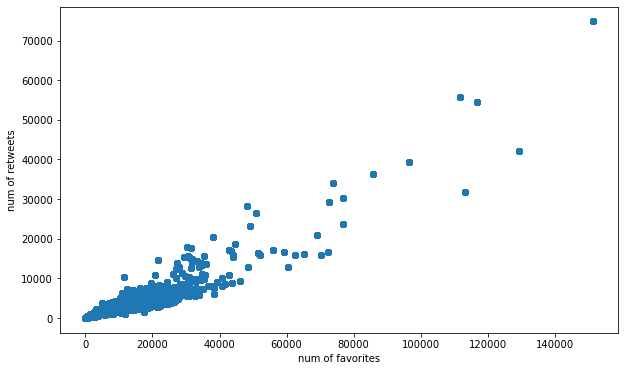

In [797]:
# Scatter plot - is there a relation between favorited tweets and the fact it's retweeted?
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_twitter_archive_master['favorites_cnt'], y = df_twitter_archive_master['retweets_cnt'])
plt.xlabel("num of favorites")
plt.ylabel("num of retweets")

plt.show()

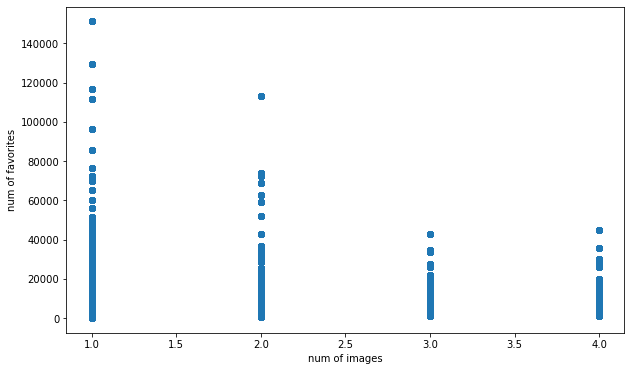

In [798]:
# scatter plot - is there a relation between num of images in picture and the fact it's favorited by users?
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_twitter_archive_master['img_num'], y = df_twitter_archive_master['favorites_cnt'])
plt.xlabel("num of images")
plt.ylabel("num of favorites")

plt.show()

Text(0, 0.5, 'count of tweets')

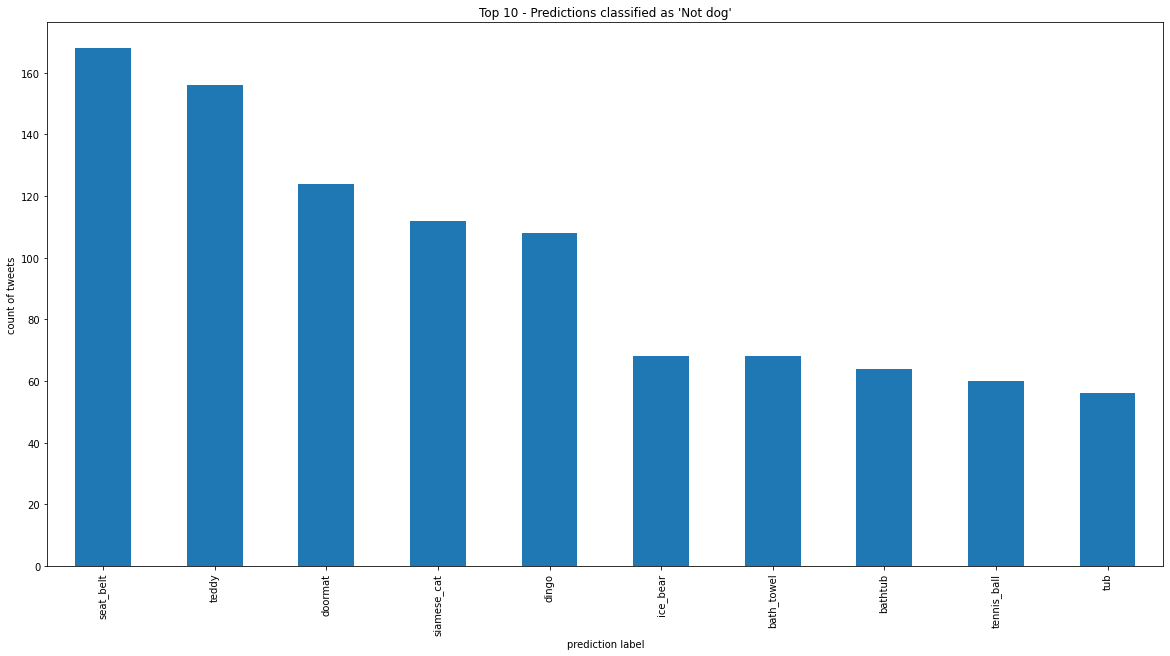

In [799]:
# Bar chart - plot predictions label for predictions classified as "not dog" (might help to improve our model)
ax = df_twitter_archive_master[(df_twitter_archive_master.preds_is_dog == False)]['predictions'].value_counts().iloc[:10]

ax1= ax.plot(kind='bar',
                                    figsize=(20,10),
                                    title="Top 10 - Predictions classified as 'Not dog'")


ax1.set_xlabel("prediction label")
ax1.set_ylabel("count of tweets")

#### Main insights:
>1. it exists a positive relationship between tweets marked as favorites and retweets \n
>2. there does not seem to be a strong and positive relation between the number of picture in a tweet the number of times it's marked as favorites - having more images to browse does not associate with greater num of favorites 1 \n
>3. analyzing the top 10 labels classified as 'not dog', one can see 'seat_belt' is ranked number one. Picture of dogs taken inside cars probably explain that and must be taken into consideration for ML model tuning.